In [1]:
# User may need to pip install SHAP to run file.
# pip install shap

In [2]:
import pandas as pd
import numpy as np
import shap
shap.initjs()
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score, roc_auc_score, accuracy_score


In [3]:
# Read in data sets - first set has denver data with outliers removed and encoded. Next set has ID and classification groupings.
df = pd.read_csv('1_denver_no_outliers_encoded_not_scaled.csv')

segments = pd.read_csv("1_pca_kmeans_seg.csv")


In [4]:
# segments.head()

rows = len(segments)
rows2 = len(df)
print({rows})
print({rows2})

{3565}
{3565}


In [5]:
# Check for nulls in rf_data and encoded_id_df so no issues when join.
null_counts = df.isnull().sum().sort_values(ascending=False)
null_counts_over0 = null_counts[null_counts > 0]
null_counts2 = segments.isnull().sum().sort_values(ascending=False)
null_counts2_over0 = null_counts2[null_counts2 > 0]
print(null_counts_over0)
print(null_counts2_over0)

Series([], dtype: int64)
Series([], dtype: int64)


In [6]:
# merge encoded dataframe with PCA cluster assigments by id

rf_classification_df = pd.merge(segments, df, on='id', how='inner')
rf_classification_df.head()



,id,customer_segments_pca,accommodates,bedrooms,beds,price,availability_30,availability_60,availability_90,availability_365,...,bath_number,prop_type_reduced_Entire condo,prop_type_reduced_Entire guest suite,prop_type_reduced_Entire guesthouse,prop_type_reduced_Entire home,prop_type_reduced_Entire rental unit,prop_type_reduced_Entire townhouse,prop_type_reduced_Other,has_availability_f,has_availability_t
0,360,1,3,2.0,2.0,90.0,4,27,57,147,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,364,3,3,1.0,1.0,179.0,23,53,83,358,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,31503,3,2,1.0,1.0,103.0,12,42,72,347,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,39405,0,2,1.0,1.0,136.0,6,7,32,114,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,154999,1,2,1.0,1.0,162.0,0,0,0,139,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
# Check for nulls in rf_data and encoded_id_df so no issues when join.
rf_nulls = rf_classification_df.isnull().sum().sort_values(ascending=False)
rf_nulls_over0 = rf_nulls[rf_nulls > 0]

print(rf_nulls_over0)


Series([], dtype: int64)


In [8]:
# Set id as index so can retain id through the split and prediction process
rf_classification_df= rf_classification_df.set_index('id')

Below section builds the random forest classification model.

We will use this to predict the segment classification.

Data is all numeric and already encoded as needed.

In [9]:
rf_classification_df.columns

Index(['customer_segments_pca', 'accommodates', 'bedrooms', 'beds', 'price',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'bath_number',
       'prop_type_reduced_Entire condo',
       'prop_type_reduced_Entire guest suite',
       'prop_type_reduced_Entire guesthouse', 'prop_type_reduced_Entire home',
       'prop_type_reduced_Entire rental unit',
       'prop_type_reduced_Entire townhouse', 'prop_type_reduced_Other',
       'has_availability_f', 'has_availability_t'],
      dtype='object')

**Notes about model optimization**

In the model optimization process, we experimented with which columns to include or remove.  
Several data points have overlapping data, and we realized we had some multicollinearity. The 
columns with overlapping data were as follows:

**Availability columns:**
-'availability_30'
-'availability_60'
-'availability_90'
-'availability_365'

**Number of review columns:**
-'number_of_reviews'
-'number_of_reviews_ltm' (last 12 months)
-'number_of_reviews_l30d' (last 30 days)

**Findings:**
We decided it was only appropriate to include 1 column from each of the topics above (availability, number of reviews) to avoid data duplication.
Through iteritive testing, we found the models were most accurate with the following columns:

-availability_60

-number_of_reviews_ltm (last 12 months)

In [10]:
# Rename columns to more understandable names

rf_classification_df.rename(columns={'number_of_reviews_ltm': 'number_of_reviews_last_12_months'}, inplace=True)



In [11]:
rf_classification_df.columns

Index(['customer_segments_pca', 'accommodates', 'bedrooms', 'beds', 'price',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews',
       'number_of_reviews_last_12_months', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'bath_number', 'prop_type_reduced_Entire condo',
       'prop_type_reduced_Entire guest suite',
       'prop_type_reduced_Entire guesthouse', 'prop_type_reduced_Entire home',
       'prop_type_reduced_Entire rental unit',
       'prop_type_reduced_Entire townhouse', 'prop_type_reduced_Other',
       'has_availability_f', 'has_availability_t'],
      dtype='object')

In [12]:
# create x and y (drop customer segments pca)


X = rf_classification_df.copy()
X.drop(['customer_segments_pca', 'availability_30', 'availability_90',
        'availability_365', 'number_of_reviews_l30d', 'number_of_reviews', 'prop_type_reduced_Entire condo',
        'prop_type_reduced_Entire guest suite',
        'prop_type_reduced_Entire guesthouse', 'prop_type_reduced_Entire home',
        'prop_type_reduced_Entire rental unit',
        'prop_type_reduced_Entire townhouse', 'prop_type_reduced_Other', 'has_availability_f', 'has_availability_t'],
        axis=1, inplace=True)
y = rf_classification_df['customer_segments_pca']


In [13]:
# get y sets into array format
y.ravel()

array([1, 3, 3, ..., 1, 3, 1], dtype=int64)

In [14]:
# train_test_split on x and y 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)


In [15]:
# See number of records in training and testing sets.
rowsXtrain = len(X_train)
rowsXtest = len(X_test)
print({rowsXtrain})
print({rowsXtest})

{2673}
{892}


In [16]:
# During model optimization, tested wide variety of n_estimators number to arrive at most efficient/most accurate
# create and fit random forest classification model 
rf_class_model = RandomForestClassifier(n_estimators=1000, random_state=1)

rf_class_model = rf_class_model.fit(X_train, y_train)


In [18]:
# make predictions

y_pred_class = rf_class_model.predict(X_test)
y_train_pred = rf_class_model.predict(X_train)


In [20]:
# Check to see if model is overfit.
# We need to look at the accuracy scores for the training and the testing data because
# here is a potential for circular logic in our classification model. This is due to the fact that
# the classifications were generated from an unsupervised model. And then the random forest classifier used that 
# same data to predict clusters.  
# Calculate accuracy on the training set
acc_score_train = accuracy_score(y_train, y_train_pred)

# Assuming y_class_pred are the predictions for the test set
acc_score_test = accuracy_score(y_test, y_pred_class)

# Display results
print(f"Accuracy Score Training Data: {acc_score_train}")
print(f"Accuracy Score Testing Data: {acc_score_test}")

Accuracy Score Training Data: 1.0
Accuracy Score Testing Data: 0.8957399103139013


In [22]:
# Print classification report for training data
print(f"Classification Report")
print(classification_report(y_train, y_train_pred))

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       463
           1       1.00      1.00      1.00       925
           2       1.00      1.00      1.00        61
           3       1.00      1.00      1.00       746
           4       1.00      1.00      1.00       478

    accuracy                           1.00      2673
   macro avg       1.00      1.00      1.00      2673
weighted avg       1.00      1.00      1.00      2673



In [21]:
# Print classification report for test data
print(f"Classification Report")
print(classification_report(y_test, y_pred_class))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       178
           1       0.89      0.91      0.90       277
           2       0.92      0.71      0.80        17
           3       0.86      0.91      0.88       237
           4       0.94      0.96      0.95       183

    accuracy                           0.90       892
   macro avg       0.90      0.86      0.88       892
weighted avg       0.90      0.90      0.90       892



In [23]:
# Get the feature importance array for availability and rating

feature_importances_segment = rf_class_model.feature_importances_


In [24]:
# Create sorted dataframe of availability features and importance scores
feature_names_segment = X_train.columns
importances_segment_df = pd.DataFrame({'Feature': feature_names_segment, 'Importance': feature_importances_segment })
importances_segment_df_sorted = importances_segment_df.sort_values(by='Importance', ascending=False)
importances_segment_df_sorted.head(20)

,Feature,Importance
4,availability_60,0.307716
5,number_of_reviews_last_12_months,0.182594
1,bedrooms,0.078638
0,accommodates,0.065241
3,price,0.064889
13,bath_number,0.048810
2,beds,0.047001
12,review_scores_value,0.038202
6,review_scores_rating,0.033399
7,review_scores_accuracy,0.029361


In [25]:
sum_top_values = importances_segment_df_sorted['Importance'].head(12).sum()
print({sum_top_values})

{0.9524966781527002}


In [26]:
len(importances_segment_df_sorted)

14

In [27]:
importances_segment_df_sorted.sum()

Feature       availability_60number_of_reviews_last_12_month...
Importance                                                  1.0
dtype: object

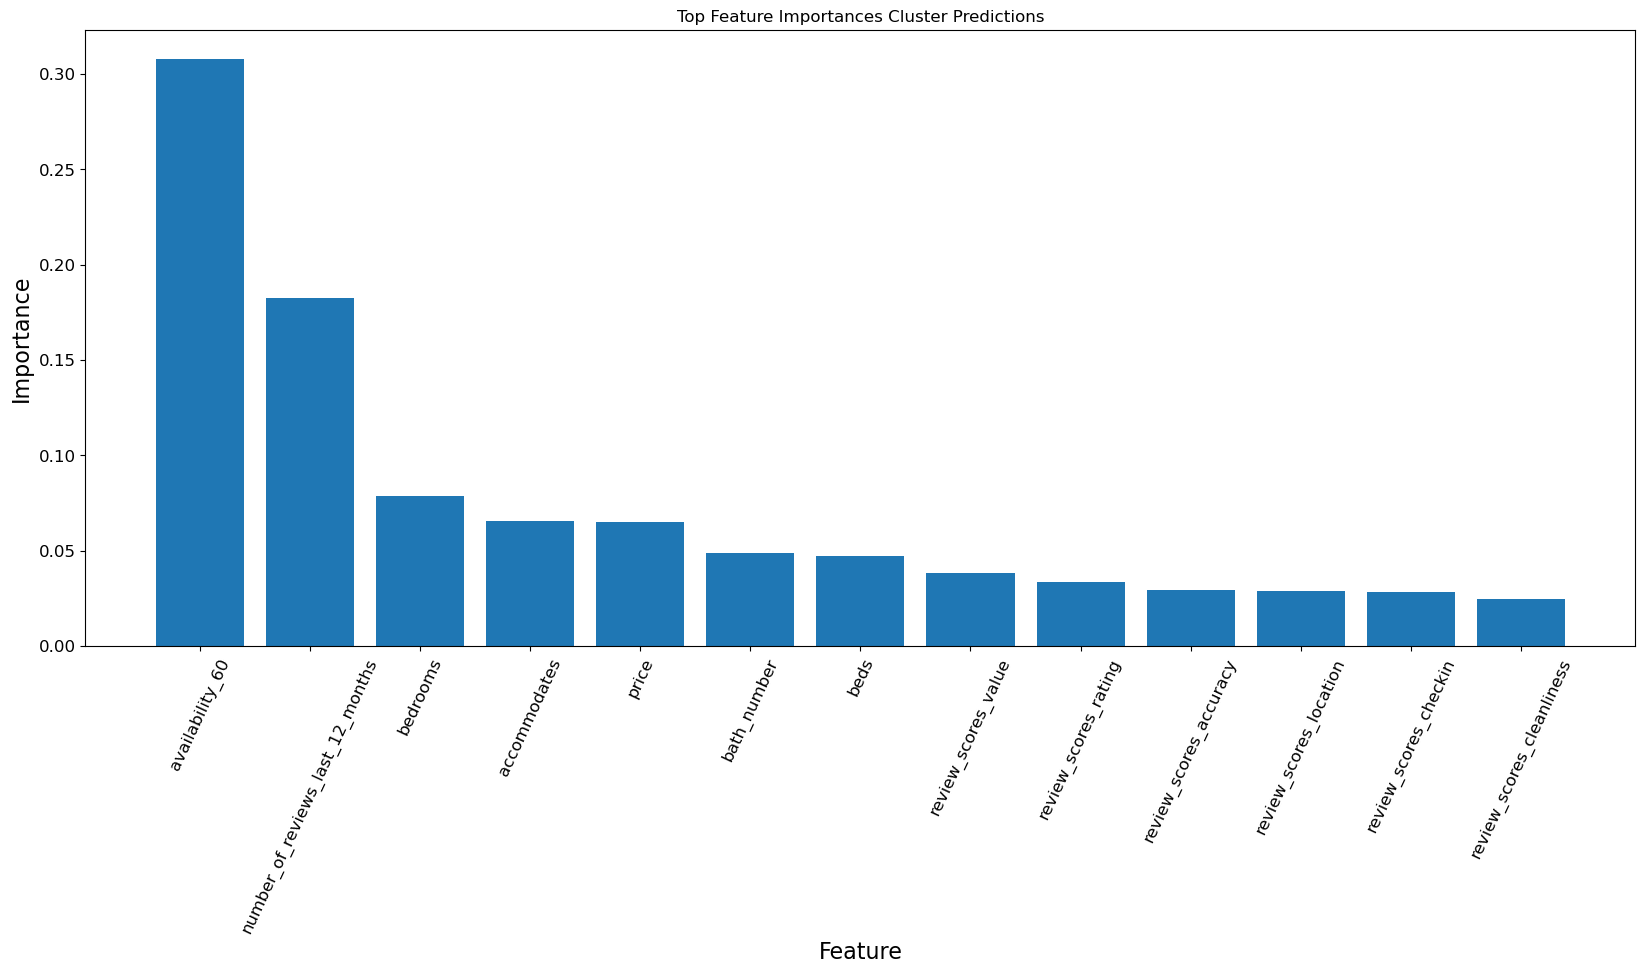

In [28]:
# plot top feature importances for segment classification

N = 13
top_features_segment = importances_segment_df_sorted.head(N)

plt.figure(figsize=(20, 8))
plt.bar(top_features_segment['Feature'], top_features_segment['Importance'])
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Importance', fontsize=16)
plt.title('Top Feature Importances Cluster Predictions')
plt.xticks(fontsize=12, rotation=65)  # Rotate x-ticks for better readability 
plt.yticks(fontsize=12)

plt.show()

In [29]:
# Set up a SHAP (SHapely Additive exPlanations) explainer to explain how the predictions were made

explainer = shap.Explainer(rf_class_model)
shap_values = explainer.shap_values(X_test)

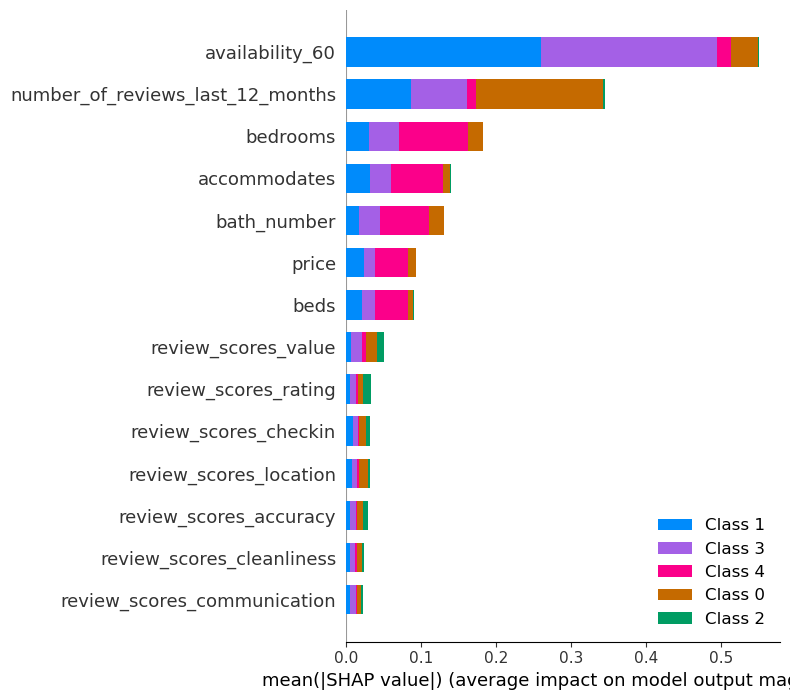

In [30]:
# plot the SHAP summary

shap.summary_plot(shap_values, X_test)
# #plt.tight_layout()
# plt.figure(figsize=(10, 8))
# plt.rcParams.update({'font.size': 4})
# plt.subplots_adjust(bottom=.7)
# plt.show()

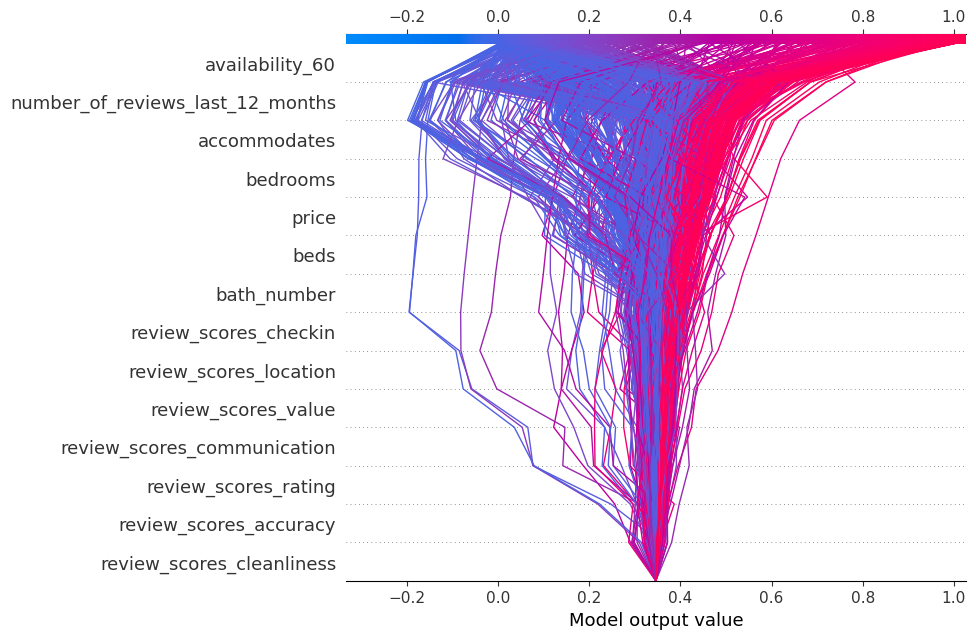

In [31]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], X_test.columns)

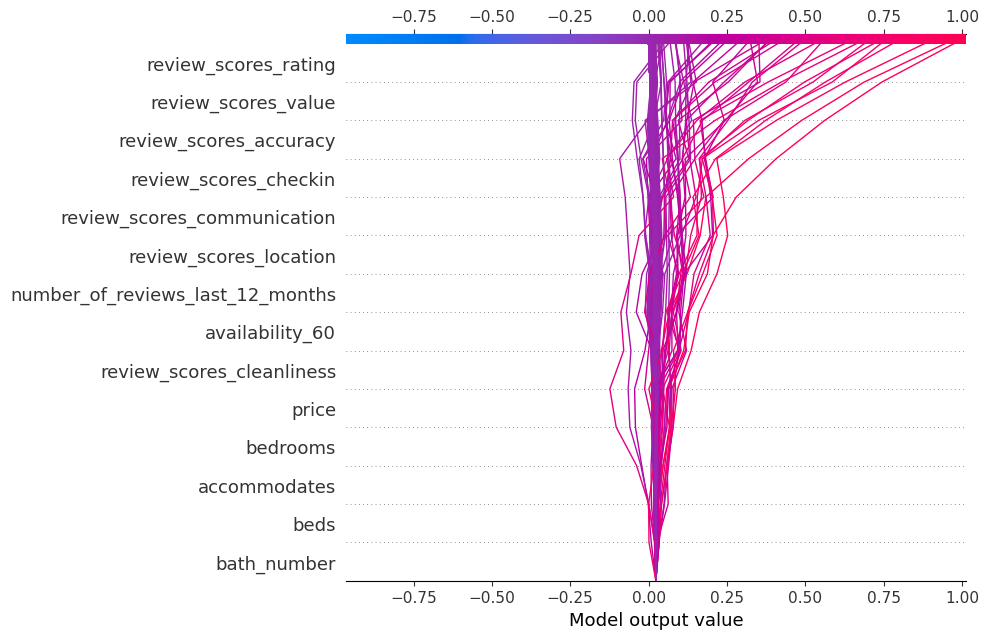

In [32]:
shap.decision_plot(explainer.expected_value[2], shap_values[2], X_test.columns)

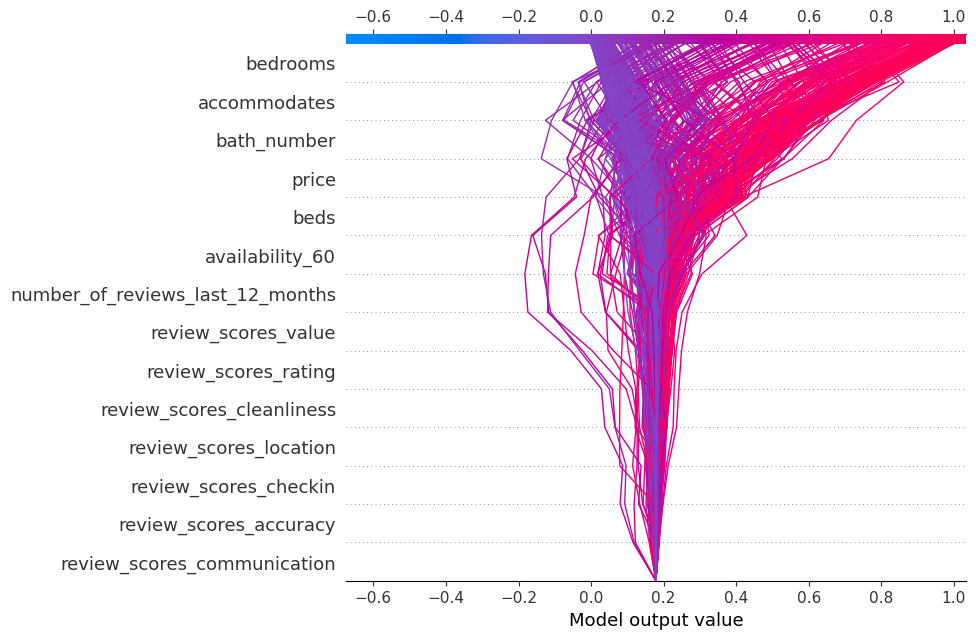

In [33]:
shap.decision_plot(explainer.expected_value[4], shap_values[4], X_test.columns)

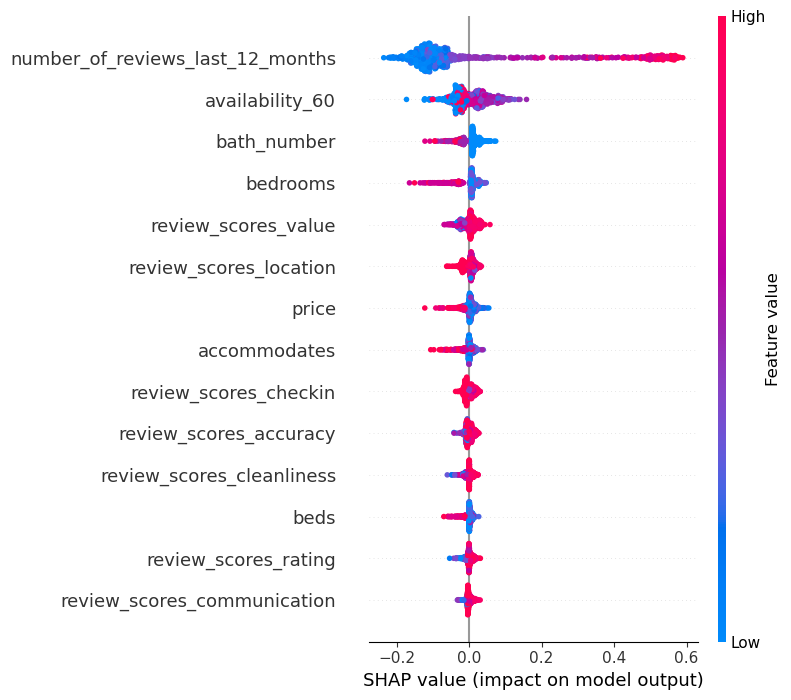

In [34]:
# Display the summary plot of the label[0]

shap.summary_plot(shap_values[0], X_test)

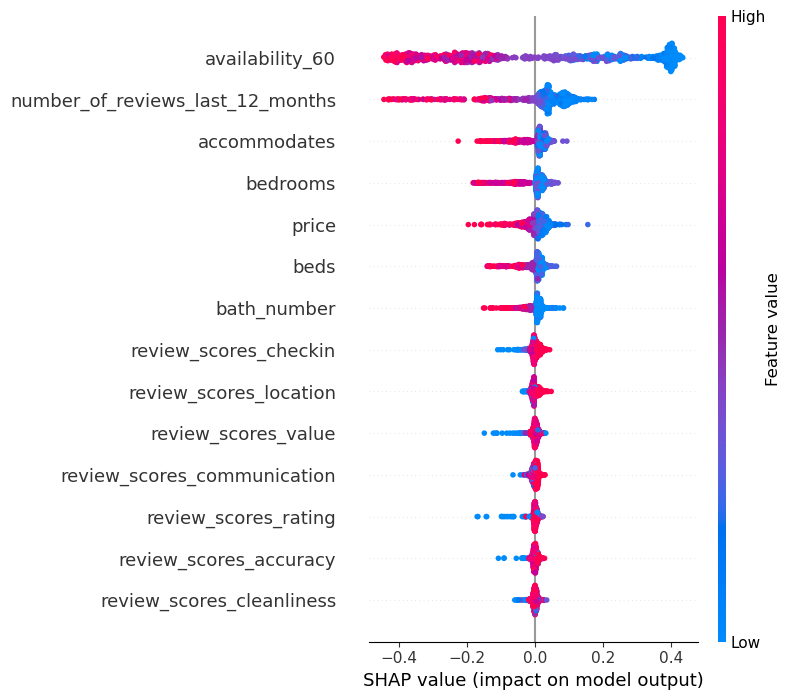

In [35]:
# Display the summary plot of the label[1]

shap.summary_plot(shap_values[1], X_test)

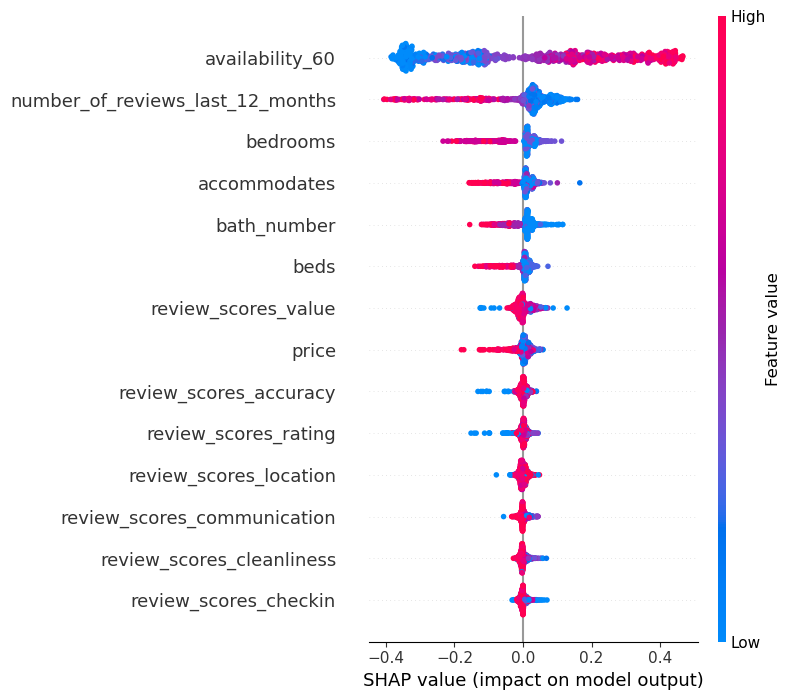

In [36]:
# Display the summary plot of the label[3]

shap.summary_plot(shap_values[3], X_test)

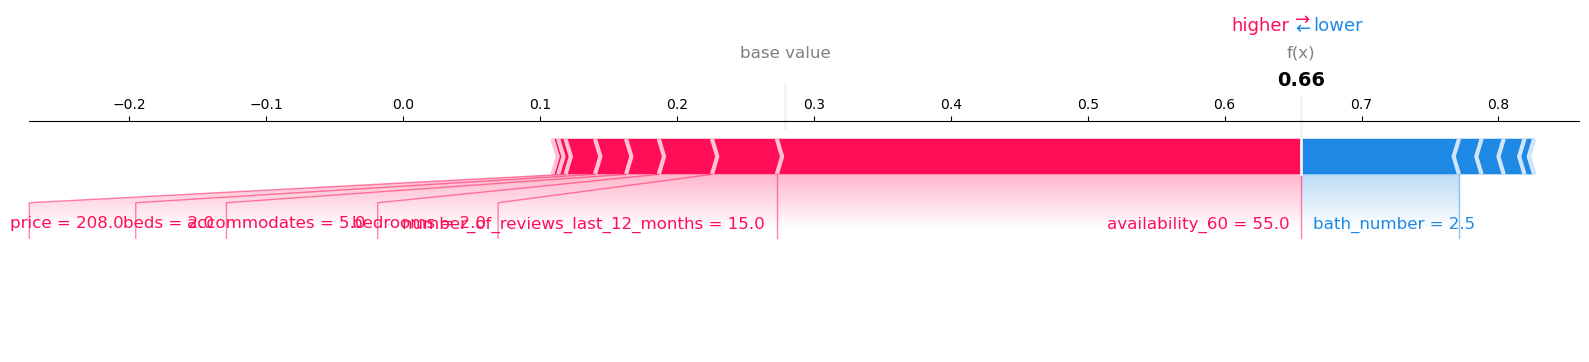

In [37]:
# This is a force plot for 1 row of data in the dataset.
shap.plots.force(explainer.expected_value[3], shap_values[3][4,:], X_test.iloc[4, :], matplotlib=True)


In [38]:
y_pred_class

array([3, 1, 3, 0, 3, 0, 1, 0, 0, 4, 4, 1, 2, 3, 0, 3, 4, 4, 3, 4, 1, 1,
       4, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 4, 3, 4, 1, 0, 3, 1, 1,
       4, 3, 0, 1, 3, 3, 4, 3, 4, 3, 1, 0, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3,
       3, 0, 3, 4, 3, 4, 1, 3, 1, 4, 4, 1, 4, 3, 0, 3, 3, 1, 0, 3, 4, 4,
       3, 1, 4, 1, 3, 0, 1, 1, 1, 0, 4, 3, 3, 1, 3, 0, 0, 3, 1, 1, 0, 3,
       1, 1, 4, 1, 1, 1, 1, 1, 0, 3, 0, 0, 1, 3, 3, 1, 4, 3, 0, 0, 1, 1,
       3, 4, 0, 1, 0, 0, 4, 4, 0, 3, 4, 1, 1, 3, 1, 3, 0, 0, 1, 1, 3, 3,
       3, 4, 1, 2, 1, 0, 1, 3, 4, 4, 0, 4, 0, 3, 0, 0, 3, 1, 3, 0, 1, 4,
       3, 3, 2, 4, 3, 1, 3, 3, 4, 2, 4, 0, 1, 1, 1, 1, 3, 4, 3, 0, 1, 4,
       0, 3, 4, 4, 0, 1, 1, 1, 3, 0, 1, 0, 4, 3, 3, 0, 3, 2, 0, 1, 3, 4,
       2, 0, 3, 1, 3, 1, 3, 4, 1, 4, 4, 4, 3, 0, 0, 1, 3, 3, 0, 0, 3, 1,
       1, 0, 0, 3, 1, 4, 0, 3, 4, 4, 0, 4, 1, 4, 3, 4, 0, 3, 1, 1, 1, 4,
       3, 1, 1, 0, 3, 3, 0, 1, 1, 4, 3, 0, 3, 3, 3, 4, 1, 1, 1, 3, 3, 3,
       4, 0, 1, 1, 1, 3, 1, 3, 4, 1, 0, 1, 1, 1, 1,